In [173]:
import numpy as np
import matplotlib.pyplot as plt

In [174]:
from loaders import clean_text_for_pattern_letter
from temp_text_puh import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=len(template_str))
# input_str = clean_text_for_pattern_letter(template_str, out_len=5000)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
111748
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [175]:
def predict_train(input_str,
                  letters,
                  max_history=4,
                  max_index: int = 4,):
    WIN: dict[str, dict[str, int]] = {}

    HistoryHW: list[dict[str, int]] = []
    HistoryW: list[dict[str, dict[str, dict[int, int]]]] = []

    for h_idx in range(max_history):
        HistoryHW.append({})
        HistoryW.append({})

    IDX: list = []

    for letter in letters:
        WIN.setdefault(letter, {})

        for idx in range(max_index):
            WIN[letter].setdefault(idx, 0)

    prev_indices = [0]

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0:
            WIN[inp][prev_indices[0]] += 1
            continue

        IDX.append(prev_indices[0])

        IdxO = {}

        for h_idx in range(max_history):
            prev_idx = inp_idx - 1 - h_idx
            if prev_idx < 0:
                break

            prev_inp = input_str[prev_idx]

            HW = HistoryHW[h_idx]
            W = HistoryW[h_idx]

            key_HW = prev_inp + str(prev_indices[h_idx]) + ':' + inp

            if HW.get(key_HW, -1) != -1:
                inp_has_index = HW[key_HW]

                IdxO.setdefault(inp_has_index, 0)
                IdxO[inp_has_index] += 1

        new_index = 0
        if len(IdxO) == 0:
            new_index = min(WIN[inp], key=WIN[inp].get)
            WIN[inp][new_index] += 1
        else:
            new_index = max(IdxO, key=IdxO.get)

        for h_idx in range(max_history):
            prev_idx = inp_idx - 1 - h_idx
            if prev_idx < 0:
                break

            prev_inp = input_str[prev_idx]

            key_I = prev_inp + str(prev_indices[h_idx])
            HistoryW[h_idx].setdefault(key_I, {})
            HistoryW[h_idx][key_I].setdefault(inp, {})
            HistoryW[h_idx][key_I][inp].setdefault(new_index, 0)
            HistoryW[h_idx][key_I][inp][new_index] += 1

            key_HW = prev_inp + str(prev_indices[h_idx]) + ':' + inp

            HistoryHW[h_idx].setdefault(key_HW, new_index)

        # recurtion
        prev_indices.insert(0, new_index)
        if len(prev_indices) > max_history:
            prev_indices = prev_indices[:-1]

    return HistoryW, HistoryHW, IDX


max_index_L1 = 32
max_history_L1 = 1

HistoryW, HistoryHW, IDX = predict_train(input_str, letters, max_history=max_history_L1, max_index=max_index_L1)

for h_idx in range(max_history_L1):
    for wk, wv in HistoryW[h_idx].items():
        print(wk, wv)


c0 {'h': {0: 18}, 'e': {4: 3}, 'l': {1: 1}, 'k': {0: 3}, 'o': {17: 3}, 'u': {11: 4}, 'i': {31: 4}}
h0 {'a': {0: 9}, 't': {4: 2}, 'e': {11: 34}, ' ': {17: 26}, 'o': {4: 11}, 'i': {11: 32}, 'r': {15: 7}, 's': {13: 1}, 'u': {3: 1}}
a0 {'p': {0: 11}, 'n': {2: 11}, 't': {13: 41}, 'k': {16: 3}, 's': {23: 8}, 'd': {0: 16}, 'l': {14: 9}, 'r': {13: 22}, 'i': {6: 17}, 'c': {19: 2}, 'v': {31: 12}, 'u': {13: 6}, 'y': {27: 6}, 'm': {18: 2}, 'g': {18: 1}, 'b': {25: 1}}
p0 {'t': {0: 3}, 'l': {6: 3}, 'r': {23: 10}, 'o': {2: 21}, 'i': {24: 17}, 'p': {18: 10}, 'e': {10: 3}, 'u': {5: 1}, ' ': {18: 2}, 'a': {25: 4}}
t0 {'e': {0: 13}, 'o': {31: 44}, 'l': {18: 2}, 'h': {28: 109}, 'r': {28: 15}, ' ': {19: 63}, 'w': {8: 5}, 'a': {1: 13}, 'u': {22: 6}, 'i': {3: 8}, 't': {17: 2}, 's': {4: 2}}
e0 {'r': {0: 23}, 'n': {20: 35}, 's': {7: 8}, 'd': {1: 33}, ' ': {17: 82}, 't': {2: 12}, 'c': {20: 5}, 'y': {17: 14}, 'e': {26: 10}, 'a': {7: 9}, 'w': {10: 2}, "'": {15: 1}, 'l': {28: 2}, 'p': {24: 6}, 'h': {28: 1}, 'i': {

In [176]:
def predict(input_str: str, 
            HistoryW: list[dict[str, dict[str, dict[int, int]]]], 
            max_history = 4,
            max_index = 4,):
    err = 0
    TF = []
    AL = []

    history_indices = []
    history_indices.append([x for x in range(max_index)])

    for input_idx, input in enumerate(input_str[:-1]):
        HO: dict[str, dict[int, int]] = {}

        for h_idx in range(max_history):
            inp_idx = input_idx - h_idx
            if inp_idx < 0:
                break
            # print(f'{h_idx=} {inp_idx=}')
            W = HistoryW[h_idx]
            inp = input_str[inp_idx]
            indices = history_indices[h_idx]

            key_I = inp + str(indices[0])
            O = W.get(key_I, {})
            # print(f'{O=}')
            # print()

            for index in indices[1:]:
                key_I = inp + str(index)

                index_O = W.get(key_I, {})
                # print(f'{index_O=}')
                # print()

                for key, val in index_O.items():
                    O.setdefault(key, {})
                    O[key].update(val)
            
            # print(f'{O=}')
            # print()
            
            for key_O, val_O in O.items():
                HO.setdefault(key_O, {})
                
                for key_index, val_index in val_O.items():
                    HO[key_O].setdefault(key_index, 0)

                    HO[key_O][key_index] += val_index

        # print(f'{HO=}')
        # print()

        length = 0
        for v in HO.values():
            length += len(v)

        max_arr = []
        for v in HO.values():
            col_max = max(v, key=v.get)
            max_arr.append(col_max)
        
        max_arr = np.array(max_arr)
        # tf = np.mean(np.abs(max_arr - max_arr[np.newaxis].T))

        tf = length
        # tf = len(HO)

        TF.append(tf)

        max_symbol = 'a'
        max_symbol_index = 0
        max_val = 0
        for key, val in HO.items():
            max_idx = max(val, key=val.get)
            HO[key] = {max_idx: val[max_idx]}

            if val[max_idx] > max_val:
                max_val = val[max_idx]
                max_symbol_index = max_idx
                max_symbol = key

        # print(f'{HO=}')
        next_inp = input_str[input_idx + 1]
        print(f'{max_symbol=}', f'{next_inp=}', max_symbol_index, max_val)

        # anomaly
        if max_symbol == next_inp:
            AL.append(0)
        else:
            ni_v = HO.get(next_inp, 0)
            if ni_v == 0:
                AL.append(100)
            else:
                max_ni = max(ni_v, key=ni_v.get)
                AL.append(abs(ni_v[max_ni] - max_val))

        new_indices = [max_symbol_index]

        # err
        if max_symbol != next_inp:
            err += 1

            index_stats = HO.get(next_inp, 0)
            
            if index_stats == 0:
                new_indices = [x for x in range(max_index)]
                print(f'{new_indices=}')
            else:
                max_symbol_index = list(index_stats.keys())[0]

                new_indices = [max_symbol_index]
        
        # recurtion
        history_indices.insert(0, new_indices)
        if len(history_indices) > max_history:
            history_indices = history_indices[:-1]

    TF.append(0)
    AL.append(0)
    return err, TF, AL

err_L1, TF_L1, AL_L1 = predict(input_str, HistoryW, max_index=max_index_L1, max_history=max_history_L1)

print(err_L1, err_L1 / (len(input_str) / 100))

max_symbol='a' next_inp='h' 2 25
max_symbol='e' next_inp='a' 27 125
max_symbol='t' next_inp='p' 15 66
max_symbol=' ' next_inp='t' 8 9
max_symbol=' ' next_inp='e' 4 64
max_symbol=' ' next_inp='r' 26 95
max_symbol=' ' next_inp=' ' 1 46
max_symbol='t' next_inp='i' 12 87
max_symbol='n' next_inp='n' 20 67
max_symbol='g' next_inp=' ' 11 78
max_symbol='t' next_inp='w' 22 119
max_symbol='h' next_inp='h' 18 24
max_symbol='e' next_inp='i' 30 52
max_symbol='n' next_inp='c' 19 46
max_symbol='h' next_inp='h' 28 17
max_symbol='e' next_inp=' ' 11 120
max_symbol='t' next_inp='w' 22 95
max_symbol='a' next_inp='e' 31 55
max_symbol=' ' next_inp=' ' 27 88
max_symbol='t' next_inp='a' 7 97
max_symbol='t' next_inp='r' 5 69
max_symbol=' ' next_inp='e' 20 37
max_symbol=' ' next_inp=' ' 24 122
max_symbol='a' next_inp='i' 16 95
max_symbol='t' next_inp='n' 6 48
max_symbol='g' next_inp='t' 17 54
max_symbol='h' next_inp='r' 26 68
max_symbol='e' next_inp='o' 3 38
max_symbol='n' next_inp='d' 25 44
max_symbol=' ' next

In [177]:
def get_TF(input_str: str, W: dict[str, dict[str, int]], IDX: list):
    TF = []

    for inp_idx, inp in enumerate(input_str[:-1]):
        index = IDX[inp_idx]

        key_I = inp + str(index)
        I = W[key_I]

        tf = len(I)

        TF.append(tf)
    
    TF.append(0)

    return TF

# TF = get_TF(input_str, W, IDX)
# print(TF)

In [178]:
def get_word_stats(input_str: str | list, TF: list, ):
    buffer: list = [input_str[0]]
    WordStats: dict[str, int] = {}

    prev_tf = TF[0]

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0:
            continue

        # if TF[inp_idx] - prev_tf > 0.0: # and abs(TF[inp_idx] - prev_tf) > 0.2:
        if TF[inp_idx] > 0:
            word = ''.join(buffer)

            WordStats.setdefault(word, 0)
            WordStats[word] += 1

            buffer = [inp]
            prev_tf = TF[inp_idx]
            
            continue

        buffer.append(inp)
        prev_tf = TF[inp_idx]
    
    # sort
    WordStats = dict(sorted(WordStats.items(), key=lambda item: item[1], reverse=True))

    return WordStats

TF_L1 = np.array(TF_L1, dtype='float64')
AL_L1 = np.array(AL_L1, dtype='float64')
TF_L1 /= np.max(TF_L1)
AL_L1 /= np.max(AL_L1)
TF_L1 += AL_L1

TF_max_coef = 0.4

# TF_L1[np.where(TF_L1 < np.mean(TF_L1))] = 0
TF_L1 = TF_L1 - np.pad(TF_L1, (1, 0))[:-1]
TF_L1[np.where(TF_L1 < 0)] = 0
TF_L1[np.where(TF_L1 < TF_max_coef)] = 0
TF_L1 = TF_L1.tolist()

WordStats_L1 = get_word_stats(input_str=input_str, TF=TF_L1)
print(len(WordStats_L1))
mean_WS = np.mean(np.array(list(WordStats_L1.values())))
print(f'{mean_WS=}')
WS_len = 0
for key, val in WordStats_L1.items():
    if len(key.strip()) > 1 and val >= mean_WS:
        WS_len += 1
    print(key, val)
print(f'{WS_len=}')

4739
mean_WS=5.946824224519941
 and 639
e 558
 h 531
 th 518
 w 490
ed 463
 b 448
 it 428
 said 399
 c 340
 of 338
 p 335
 y 335
er 311
ou 254
 f 247
en 229
et 223
 i 222
 g 212
 m 209
 pooh 209
 r 205
 wh 184
 to 176
 in 171
 the 168
ooh 159
 pigl 159
 d 156
 his 154
 l 154
 that 149
ey 144
as 142
 he 141
ery 137
es 136
 v 130
ere 122
 is 110
 but 109
 all 108
ear 105
 up 101
 you 100
ell 100
 s 98
 j 97
 if 95
 k 95
 was 95
or 94
 as 93
at 91
 som 90
 at 87
 him 86
ing 80
em 78
 eey 77
ent 75
ay 74
 a 72
 out 72
 owl 71
 on 70
 n 69
ad 69
om 67
ot 67
toph 66
 look 65
er robin 64
 lik 64
 had 63
 what 62
 so 61
 now 58
ething 56
ould 55
out 55
 with 55
av 55
it 55
 this 54
ead 50
 by 50
 christopher 49
ar 49
ec 48
 for 48
 chris 47
all 47
 q 47
 my 47
 ev 46
 ab 46
 down 46
 robin 45
ev 45
t 44
 oh 44
een 44
ore 44
ody 43
 rob 42
e said 42
in 41
 not 39
elf 38
 hav 38
ood 38
igl 38
e w 37
 did 36
s 36
 fr 36
oing 35
 ' 35
 ov 35
eff 35
 only 34
ust 34
 rabb 34
 kang 34
 think 32
 woul

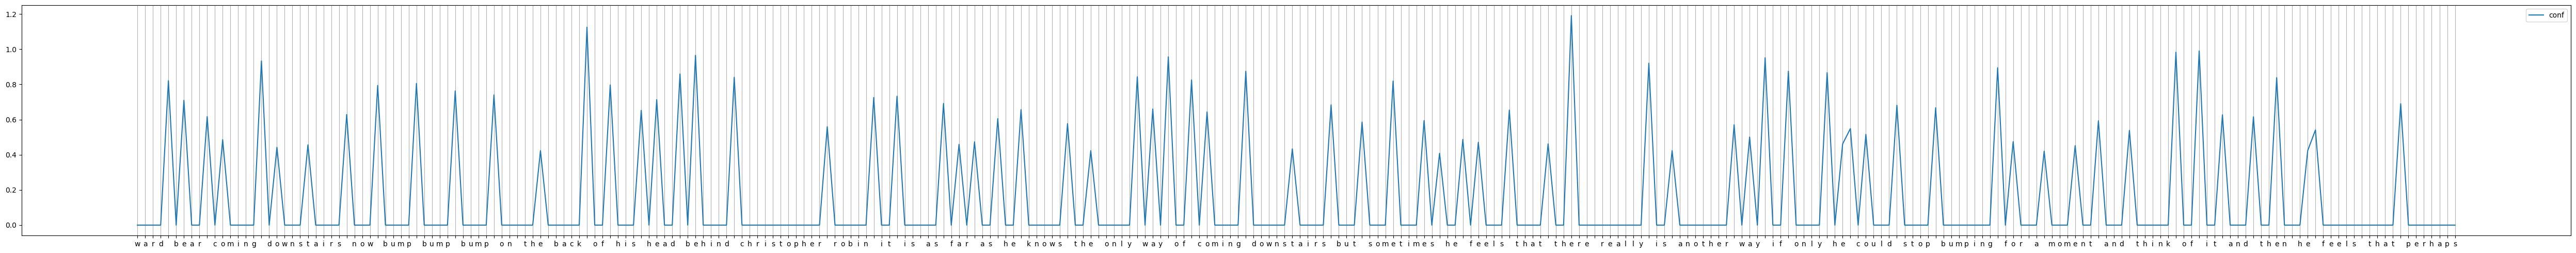

In [179]:
begin = 100
length = 400

arr_TF = np.array(TF_L1, dtype=float)

# arr_TF += 1e-30
# arr_TF = 1 / arr_TF
# arr_TF = np.pad(arr_TF, (1, 0))[:-1] - arr_TF
# arr_TF[arr_TF > 0] = 0
# arr_TF = np.abs(arr_TF)

# arr_TF /= np.max(arr_TF)
arr_TF = arr_TF[begin:length]

arr_AL = np.array(AL_L1, dtype=float)
arr_AL /= np.max(arr_AL)
arr_AL = arr_AL[begin:length]

arr_TA = arr_TF + arr_AL

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
axs.plot(np.arange(arr_TF.size), arr_TF, label='conf')
# axs.plot(np.arange(arr_AL.size), arr_AL, label='anom')

# axs.plot(np.arange(arr_TA.size), arr_TA, label='ca')

axs.xaxis.set_ticks(np.arange(len(input_str[begin:length])), input_str[begin:length])
axs.xaxis.grid(True)

plt.legend()
plt.show()